In [ ]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
%cd drive/MyDrive/stat430\ final\ project

/content/drive/MyDrive/stat430 final project


In [ ]:
!pwd

/content/drive/MyDrive/stat430 final project


In [ ]:
!ls

'cDCGAN Results'   testdata   traindata


In [ ]:
transform = Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
dataset_train = datasets.ImageFolder(root='traindata/', transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64,
                                           shuffle=True)

In [ ]:
dataset_test = datasets.ImageFolder(root='testdata/', transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=64,
                                           shuffle=False)

In [ ]:
# training parameters
BATCH_SIZE = 64
LR = 0.0002
EPOCH = 100
img_size = 32

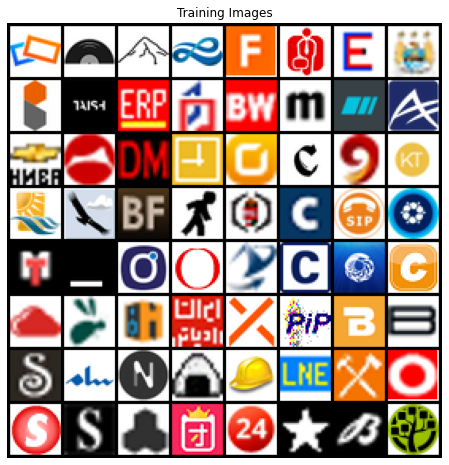

In [ ]:
# Plot some training images, 
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
real_batch[0].shape

torch.Size([64, 3, 32, 32])

In [ ]:
real_batch[1].shape

torch.Size([64])

In [ ]:
Z_DIM = 100
Y_DIM = NUM_CLASS = 4

In [ ]:
%%capture output
# test architecture
!pip3 install pytorch_model_summary
from pytorch_model_summary import summary

In [ ]:
def normal_init(m, mean, std):
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()

In [ ]:
class generator(nn.Module):
  # Paper Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S

        # self.deconv1_1 = nn.ConvTranspose2d(100, 128*2, 4, 1, 0)
        # self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        # self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        # self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        # self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        # self.deconv2_bn = nn.BatchNorm2d(d*2)
        # self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        # self.deconv3_bn = nn.BatchNorm2d(d)
        # self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

  def __init__(self):
    super(generator,self).__init__()
    self.h1 = nn.Sequential(
    nn.Linear(in_features=Z_DIM+Y_DIM, out_features=256 * 4 * 4),
    nn.LeakyReLU(negative_slope=0.2),)
    
    # upsample n*n -> 2n * 2n
    self.up1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
        # 128 is the channel size, should match with the real image data loader,H = (H1 - 1)*stride + HF - 2*padding
        nn.LeakyReLU(negative_slope=0.2)
    )
    self.up2 = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(negative_slope=0.2)
    )
    self.output = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, padding=1),  # 3 means the RGB channel
        nn.Tanh()
    )

  def forward(self, x,label):
    x = torch.cat([x,label],1)
    # print("x after concatenate: ",x.shape) # [64, 112]
    out = self.h1(x)
    # print("shape after the first hidden layer: ",out.shape) #[64, 4096]
    # print("shape after the first hidden layer: ",out.shape)
    out = out.view(-1, 256, 4, 4)
    out = self.up1(out)
    out = self.up2(out)
    out = self.up2(out)  # [64, 128, 32, 32]
    # print("shape after up2: ",out.shape)
    out = self.output(out)
    return out

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
        normal_init(self._modules[m], mean, std)

In [ ]:
g = generator()
print(summary(g, torch.zeros(64,100),torch.zeros(64,NUM_CLASS)))

---------------------------------------------------------------------------
        Layer (type)          Output Shape         Param #     Tr. Param #
            Linear-1            [64, 4096]         430,080         430,080
         LeakyReLU-2            [64, 4096]               0               0
   ConvTranspose2d-3       [64, 128, 8, 8]         524,416         524,416
         LeakyReLU-4       [64, 128, 8, 8]               0               0
   ConvTranspose2d-5     [64, 128, 16, 16]         262,272         262,272
         LeakyReLU-6     [64, 128, 16, 16]               0               0
            Conv2d-7       [64, 3, 32, 32]           3,459           3,459
              Tanh-8       [64, 3, 32, 32]               0               0
Total params: 1,220,227
Trainable params: 1,220,227
Non-trainable params: 0
---------------------------------------------------------------------------


In [ ]:
class discriminator(nn.Module):
  # Paper Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S

  def __init__(self):
    super(discriminator, self).__init__()
    # input size: [batch_size, channel, height, width ] [64,3,32,32]
    self.batch_size = 64
    self.conv = nn.Sequential(
        # normal [64,32,32] padding=1 to keep shape the same
        nn.Conv2d(in_channels=3+1, out_channels=64, kernel_size=3, padding=1),
        nn.LeakyReLU(negative_slope=0.2),

        # down sampling [128,32,32]
        # nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=17),
        # nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.LeakyReLU(negative_slope=0.2),
        #
        # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=17),#[256,32,32]
        # nn.LeakyReLU(negative_slope=0.2),
        # classifier
        nn.Flatten(),
        nn.Dropout(p=0.4)
    )
    self.fc = nn.Sequential(
        nn.Linear(in_features=256 * 32 * 32, out_features=1),
        nn.Sigmoid()  # may be not proper to use sigmoid for binary classification problem?
    )

    # following layer is for processing label:
    self.process_label = nn.Sequential(
        nn.Linear(in_features = NUM_CLASS,out_features=1*32*32),
        nn.LeakyReLU(negative_slope=0.2)
    )

  def forward(self, x,label):
    # need to let the shape of the label become (batch_size,1,32,32), now it's (batch_size,12)
    label = self.process_label(label)
    label = torch.reshape(label,(-1,1,32,32))

    # print("label shape after reshape: ",label.shape)
    x = torch.cat([x,label],1)
    out = self.conv(x)
    out = out.view(-1, 256 * 32 * 32)
    out = self.fc(out)
    return out

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
        normal_init(self._modules[m], mean, std)


In [ ]:
d = discriminator()
print(summary(d, torch.zeros(64, 3, 32, 32),torch.zeros(64,NUM_CLASS)))

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Linear-1            [64, 1024]           5,120           5,120
       LeakyReLU-2            [64, 1024]               0               0
          Conv2d-3      [64, 64, 32, 32]           2,368           2,368
       LeakyReLU-4      [64, 64, 32, 32]               0               0
          Conv2d-5     [64, 128, 32, 32]          73,856          73,856
       LeakyReLU-6     [64, 128, 32, 32]               0               0
          Conv2d-7     [64, 256, 32, 32]         295,168         295,168
       LeakyReLU-8     [64, 256, 32, 32]               0               0
         Flatten-9          [64, 262144]               0               0
        Dropout-10          [64, 262144]               0               0
         Linear-11               [64, 1]         262,145         262,145
        Sigmoid-12               [64, 1]          

In [ ]:
# label helper
MAP = torch.diag(torch.ones(NUM_CLASS))
MAP

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [ ]:
def label_preprocess(label):
  # change the label from dataloader in (batch_size,) to (batch_size,num_class)
  label = label.type(torch.LongTensor)
  return MAP[label]

In [ ]:
# test for function label_preprocess(label)
tst = torch.zeros(2)
label_preprocess(tst)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [ ]:
# for the purpose of designing logos using the same random numbers each time during training
NUM_TEST = NUM_CLASS*NUM_CLASS
fixed_z = torch.randn(NUM_TEST,100).to(device)
test_label = torch.randint(NUM_CLASS, (NUM_TEST,))
fixed_y = label_preprocess(test_label).to(device)
print("random inputs for test: ",fixed_z.shape)
print("random class for test: ",fixed_y.shape)

random inputs for test:  torch.Size([16, 100])
random class for test:  torch.Size([16, 4])


In [ ]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z, fixed_y)
    G.train()

    size_figure_grid = 4 # 每一次每一类展示4*4个图
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy())#, cmap='gray'

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
# network
G = generator()
D = discriminator()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.to(device)
D.to(device)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=LR, betas=(0.9, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=LR, betas=(0.9, 0.999))

In [ ]:
# results save folder
root = 'cDCGAN Results/'
model = 'cDCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):# save generated result by generator
    os.mkdir(root + 'Fixed_results')

In [ ]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
img_size = 32

In [ ]:
print('training start!')
start_time = time.time()
for epoch in range(EPOCH):
    D_losses = []
    G_losses = []

    # learning rate decay
    if (epoch+1) == 11:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    if (epoch+1) == 16:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    epoch_start_time = time.time()
    y_real = torch.ones(BATCH_SIZE).to(device)
    y_fake = torch.zeros(BATCH_SIZE).to(device)

    for img, label in train_loader:
        # for sake of total sample size is not divisible by batch_size
        mini_batch = img.size()[0]
        if mini_batch != BATCH_SIZE:
            y_real = torch.ones(mini_batch).to(device)
            y_fake = torch.zeros(mini_batch).to(device)
        img,label_onehot = img.to(device),label_preprocess(label).to(device) # real and fake use the same label now

        # generate random noise
        z = torch.randn(img.size(0),100).to(device)

        # generate fake image by generator
        # print("label: ",label_onehot.shape)
        fake_img = G(z,label_onehot).to(device)
        # print("data preprocessing done!")
        #-------------------data preprocessing done above-----------------------


        D.zero_grad()

        D_result = D(img, label_onehot).squeeze()

        D_real_loss = BCE_loss(D_result, y_real)

        G_result = G(z, label_onehot)
        D_result = D(G_result, label_onehot).squeeze()

        D_fake_loss = BCE_loss(D_result, y_fake)
        # D_fake_score = D_result.data.mean()
        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())
        # print("discriminator training done!")

        # train generator G
        G.zero_grad()

        G_result = G(z, label_onehot)
        D_result = D(G_result, label_onehot).squeeze()

        G_train_loss = BCE_loss(D_result, y_real)

        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())
        # print("generator training done!")
        print(D_losses)




        # # train discriminator
        # D.zero_grad()

        # D_real_output = D(img, label_onehot).squeeze() # squeeze to change from (batch_size,1) to (batch_size,)
        # D_real_loss = BCE_loss(D_real_output, y_real)
        # D_fake_output = D(fake_img,label_onehot).squeeze()
        # D_fake_loss = BCE_loss(D_fake_output, y_fake)
        # D_total_loss = D_real_loss+D_fake_loss
        # D_losses.append(D_total_loss.item())

        # # D_optimizer.zero_grad()# why don't need this?
        # D_total_loss.backward()
        # D_optimizer.step()

        # # calculate the accuracy of discriminator on real/fake data
        # D_real_acc = (D_real_output>0.5).float().mean().item()# if want boolean to int, use .long()
        # D_fake_acc = (D_fake_output<=0.5).float().mean().item()

        # #---------------discriminator training done above-----------------------

        # # train generator G
        # G.zero_grad()
        # G_total_loss = BCE_loss(D_fake_output, y_real)# notice: y_real but not y_fake!
        # G_losses.append(G_total_loss.item())

        # # G_optimizer.zero_grad()# why don't need this?
        # G_total_loss.backward()
        # G_optimizer.step()

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), EPOCH, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

training start!
[1.394240379333496]
[1.394240379333496, 1.1096640825271606]
[1.394240379333496, 1.1096640825271606, 0.8675074577331543]
[1.394240379333496, 1.1096640825271606, 0.8675074577331543, 0.606702446937561]
[1.394240379333496, 1.1096640825271606, 0.8675074577331543, 0.606702446937561, 0.4080258905887604]
[1.394240379333496, 1.1096640825271606, 0.8675074577331543, 0.606702446937561, 0.4080258905887604, 0.23317845165729523]
[1.394240379333496, 1.1096640825271606, 0.8675074577331543, 0.606702446937561, 0.4080258905887604, 0.23317845165729523, 0.11799197643995285]
[1.394240379333496, 1.1096640825271606, 0.8675074577331543, 0.606702446937561, 0.4080258905887604, 0.23317845165729523, 0.11799197643995285, 0.05685770884156227]
[1.394240379333496, 1.1096640825271606, 0.8675074577331543, 0.606702446937561, 0.4080258905887604, 0.23317845165729523, 0.11799197643995285, 0.05685770884156227, 0.024736955761909485]
[1.394240379333496, 1.1096640825271606, 0.8675074577331543, 0.606702446937561, 

KeyboardInterrupt: ignored

In [ ]:
end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), EPOCH, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), root + model + 'generator_param.pkl')
torch.save(D.state_dict(), root + model + 'discriminator_param.pkl')
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(20):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

Avg one epoch ptime: 5.66, total 100 epochs ptime: 466.07
Training finish!... save training results
